NLP

In [38]:
#!pip install tensorflow_text

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
# imports
import os
import tensorflow as tf
import re
import numpy as np
import tensorflow_text as tf_text
from collections import Counter
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


# define the hyperparameters
vocab_size = 10000
embedding_size = 64

2.1 Dataset

In [41]:
from google.colab import drive
drive.mount ("/content/drive")
os.chdir ("/content/drive/MyDrive")
bible = open("bible.txt").read()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**2.2 Word Embeddings** <br>
-> convert to lower case <br>
-> tokenize into word tokens <br>
-> use only 10 000 most common words <br>
-> create input-target pairs with a context window of 4 <br>

In [42]:
#Step 1: Preprocess bible data
# tokenize and preprocess into word tokens
bible = bible.lower()
bible = re.sub('[^a-z ]+', '', bible)
tokens = tf_text.WhitespaceTokenizer().split(bible)

#save tokens as list
tokens = list(tokens.numpy())
#convert the tokens from uft8 to string
tokens  = [x.decode('utf8') for x in tokens]

print("Total words: {}".format(len(tokens)))
print("Unique words: {}".format(len(set(tokens))))


# only use most common tokens according to vocab_size
most_common = Counter(tokens).most_common(vocab_size)
#drop the counts
most_common = [x[0] for x in most_common]
print("Tokens sorted by count:", most_common)

#Step 2: create vocabulary
char_to_int = dict((c,i) for i,c in enumerate(most_common))
int_to_char = dict((i,c) for i,c in enumerate(most_common))
print("Vocabulary:",char_to_int)

#remove uncommon token from bible text
def keep_tokens(tokens, tokens_to_keep):
    tokens_to_keep_set = set(tokens_to_keep)
    return [token for token in tokens if token in tokens_to_keep_set]

new_bible = keep_tokens(tokens,most_common)

#translate bible into our vocabulary                  
trans_bible = np.vectorize(lambda x: char_to_int.get(x, 0))(new_bible)

# Step 3: apply subsampling: discard words in the text when they appear very often
# calculate the word frequencies
word_counts = dict(Counter(new_bible))
s = 1e-5 # control constant for subsampling
threshold = 1e-3 # discard words that have probability less than this threshold
keep_probs = {word: (np.sqrt(word_counts[word]/s) + 1) * s/word_counts[word] for word in word_counts}
new_bible = [word for word in new_bible if keep_probs[word] > threshold]

# Step 4: create dataset of input-target pairs
pairs = []

for i in range(vocab_size):
    for j in range(i-2, i+3):
        if j >= 0 and j < vocab_size and trans_bible[i] != trans_bible[j] :
          pairs.append((trans_bible[i], trans_bible[j]))

# convert pairs into a dataset
pairs = tf.data.Dataset.from_tensor_slices(pairs)
pairs = pairs.shuffle(10000).batch(64)

Total words: 740790
Unique words: 36951
Tokens sorted by count: ['the', 'and', 'of', 'to', 'in', 'that', 'he', 'shall', 'i', 'for', 'unto', 'a', 'his', 'lord', 'they', 'is', 'be', 'him', 'not', 'them', 'it', 'with', 'all', 'thou', 'was', 'god', 'thy', 'my', 'which', 'me', 'but', 'said', 'ye', 'will', 'have', 'thee', 'their', 'as', 'from', 'when', 'are', 'out', 'this', 'upon', 'were', 'by', 'you', 'man', 'israel', 'son', 'up', 'there', 'then', 'king', 'hath', 'came', 'people', 'on', 'had', 'come', 'house', 'into', 'her', 'one', 'we', 'also', 'day', 'so', 'children', 'your', 'before', 'if', 'land', 'men', 'an', 'at', 'let', 'shalt', 'against', 'go', 'hand', 'us', 'now', 'went', 'made', 'saying', 'do', 'no', 'even', 'behold', 'saith', 'therefore', 'these', 'every', 'because', 'after', 'sons', 'our', 'o', 'things', 'or', 'down', 'say', 'make', 'may', 'did', 'david', 'she', 'hast', 'earth', 'jesus', 'over', 'what', 'who', 'father', 'put', 'name', 'am', 'any', 'among', 'away', 'great', 'thin

Model

In [43]:
import tensorflow as tf

class SkipGram(tf.keras.layers.Layer):
    """
    SkipGram class, a subclass of `tf.keras.layers.Layer` for training word embeddings.
    """
    def __init__(self, vocab_size, embedding_size, word_frequency=None):
        """
        Initialize the SkipGram layer with the given vocabulary size and embedding size.
        
        Args:
        vocab_size (int): the size of the vocabulary, i.e., the number of unique words.
        embedding_size (int): the size of the embedding vector for each word.
        word_frequency (np.array, optional): an array of size `vocab_size` representing the frequency of each word in the corpus.
        
        Returns:
        None
        """
        super(SkipGram, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.word_frequency = word_frequency
        self.build()
        
    def build(self):
        """
        Build the embedding and score matrix variables.
        
        Returns:
        None
        """
        self.embeddings = self.add_weight(shape=(self.vocab_size, self.embedding_size),
                                         initializer='random_normal', trainable=True)
        self.score_matrix = self.add_weight(shape=(self.vocab_size, self.embedding_size),
                                           initializer='random_normal', trainable=True)
     
    def __call__(self, inputs, target):
        """
        Compute the NCE loss for the given inputs and target word.

        Args:
        inputs (tf.Tensor): a tensor of word indices representing the input words.
        target (tf.Tensor): a tensor of word indices representing the target words.

        Returns:
        loss (tf.Tensor): a scalar tensor representing the NCE loss.
        """
        embeddings = tf.nn.embedding_lookup(self.embeddings, inputs)

        target = tf.expand_dims(target, axis=-1)
        inputs = tf.cast(inputs, tf.int64)
        target = tf.cast(target, tf.int64)
        sampled_values = tf.random.fixed_unigram_candidate_sampler(
            true_classes=target,
            num_true=1,
            num_sampled=64,
            unique=True,
            range_max=self.vocab_size,
            distortion=0.75,
            unigrams=[1.0 for i in range(self.vocab_size)]
        )
        loss = tf.reduce_mean(tf.nn.nce_loss(
            weights=self.score_matrix,
            biases=tf.zeros(self.vocab_size),
            labels=target,
            inputs=embeddings,
            num_sampled=64,
            num_classes=self.vocab_size,
            sampled_values=sampled_values
        ))
        return loss




In [44]:
def training_loop(optimizer,words_to_investigate,num_epochs,k):
  """
  This function trains the model using the specified optimizer for a given number of epochs and visualizes the training loss.
  It also calculates the cosine similarity between the word embeddings and prints out the k-nearest neighbors of specified words.

  Arguments:
      optimizer (tf.keras.optimizers): The optimizer used for training.
      words_to_investigate (list): A list of words to investigate their nearest neighbors during training.
      num_epochs (int): The number of epochs to train the model.
      k(int): The number of nearest neighbprs to be printed.

  Returns:
      list: A list of average loss values for each epoch.
  """
  #list to store training loss
  vis_loss = []

  for epoch in range(num_epochs):
    total_loss = 0

    #train step
    for batch in pairs:
      input = batch[:, 0]
      target = batch[:, 1]
      with tf.GradientTape() as tape:
        loss = model(input, target)
        gradients = tape.gradient(loss, model.trainable_variables)
      
      optimizer.apply_gradients(zip(gradients, model.trainable_variables))
      total_loss += loss
    
    #visualize the loss
    average_loss = total_loss / len(pairs)
    vis_loss.append(average_loss)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}')

    #get the model embeddings
    embs = model.trainable_variables[0].numpy()

    #calculate the k nearest neighbors of the words we want to investigate using cosine similarity and print the words
    for i in range(len(words_to_investigate)):
      word_idx = char_to_int[words_to_investigate[i]]
      word_embedding = embs[word_idx, :]
      cos_sim = np.matmul(embs, word_embedding)
      nearest_k = np.argsort(-cos_sim)[:k]
      #if the word to be investigate is among the nearest neighbors, exchange it with the next nearest neighbor
      if  word_idx in nearest_k :
        nearest_k = np.delete(nearest_k, np.where(nearest_k == word_idx))
        nearest_k  = np.append(nearest_k,np.argsort(-cos_sim)[k: k + 1]) 
      print("Top " + str(k) + " nearest neighbours of " + tf.compat.as_str_any(words_to_investigate[i]) + " are: ")
      for nn in nearest_k:
        print(tf.compat.as_str_any(int_to_char[nn]))
      print("\n")
    print("\n")

  return vis_loss


Training loop

Epoch 1/10, Loss: 130.69546508789062
Top 5 nearest neighbours of holy are: 
untomy
howthat
unleavened
thedead
theinhabitants


Top 5 nearest neighbours of father are: 
earth
begat
sons
upon
god


Top 5 nearest neighbours of wine are: 
earth
begat
sons
upon
god


Top 5 nearest neighbours of poison are: 
begat
land
days
forth
upon


Top 5 nearest neighbours of love are: 
god
waters
them
lord
be


Top 5 nearest neighbours of strong are: 
note
charity
stirreth
honourable
thanksgiving


Top 5 nearest neighbours of day are: 
earth
begat
sons
upon
god




Epoch 2/10, Loss: 7.4710307121276855
Top 5 nearest neighbours of holy are: 
untomy
howthat
unleavened
thedead
theinhabitants


Top 5 nearest neighbours of father are: 
ark
daughters
face
earth
beast


Top 5 nearest neighbours of wine are: 
ark
daughters
face
earth
beast


Top 5 nearest neighbours of poison are: 
forth
days
kind
ark
are


Top 5 nearest neighbours of love are: 
made
god
waters
came
tree


Top 5 nearest neighbours of strong are

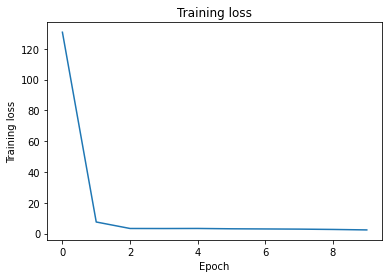

In [45]:
# create the model
model = SkipGram(vocab_size, embedding_size)

# define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# choose the words we want to keep track of
words_to_investigate = ['holy', 'father', 'wine', 'poison', 'love', 'strong', 'day']

#train the model
vis_loss = training_loop(optimizer,words_to_investigate,10,5)

#visualization of the training loss
plt.figure()
line1, = plt.plot(vis_loss)
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.title("Training loss")
plt.show()